In [1]:
!pip install -U -q PyDrive
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [2]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
ARTISTS_FILE = 'artists.txt'
file_id = '1mu2IxXf_omIh2LYLlYErXNY3t2OlAhph' # artists.txt
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(ARTISTS_FILE)

USER_ARTISTS_SM_FILE = 'user_artists_small.txt'
file_id = '1ZCU7BFAgZC7nvkTJIk4S-JQh_MoZECCC' # user_artists_small.txt
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(USER_ARTISTS_SM_FILE)

USER_ARTISTS_FILE = 'user_artists.txt'
file_id = '1Cfk6hl4Rgii0SIEUP4jolWiGBzzlYtq3' # user_artists.txt
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(USER_ARTISTS_FILE)

In [3]:
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve

from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
l = []
with open(ARTISTS_FILE, 'r') as f:
    l = f.readlines()
l = list( map(lambda s: s.split('\t'), list(map(str.strip, l))) )
artists = {k: v for k, v in l}

In [5]:
l2 = []
with open(USER_ARTISTS_SM_FILE, 'r') as f:
    l2 = f.readlines()
l2 = list( map(str.split, list(map(str.strip, l2))) )

In [6]:
l3 = []
with open(USER_ARTISTS_FILE, 'r') as f:
    l3 = f.readlines()
l3 = list( map(str.split, list(map(str.strip, l3))) )

In [7]:
user_artists_sm_df = pd.DataFrame(l2[1:], columns = l2[0], dtype=int)
user_artists_df = pd.DataFrame(l3[1:], columns = l3[0], dtype=int)

In [8]:
USER_N_SM = 100.0
ARTIST_M_SM = 100.0

USER_N = 1882.0
ARTIST_M = 3000.0

In [9]:
alpha_sm = (((user_artists_sm_df[['interactions']] != 0).sum(axis=0)) / ((USER_N_SM * ARTIST_M_SM) - ((user_artists_sm_df[['interactions']] != 0).sum(axis=0))))[0]
alpha = (((user_artists_df[['interactions']] != 0).sum(axis=0)) / ((USER_N * ARTIST_M) - ((user_artists_df[['interactions']] != 0).sum(axis=0))))[0]

print(f'The sparsity ratio for {USER_ARTISTS_SM_FILE} is {alpha_sm}')
print(f'The sparsity ratio for {USER_ARTISTS_FILE} is {alpha}')

The sparsity ratio for user_artists_small.txt is 0.027221366204417053
The sparsity ratio for user_artists.txt is 0.011265055687640536


In [10]:
user_artists_sm_df.isnull().sum(axis = 0)

userID          0
artistID        0
interactions    0
dtype: int64

In [11]:
user_artists_df.isnull().sum(axis = 0)

userID          0
artistID        0
interactions    0
dtype: int64

In [12]:
user_artists_sm_df.head()

,userID,artistID,interactions
0,0,45,13883
1,0,46,11690
2,0,47,11351
3,0,48,10300
4,0,49,8983


In [13]:
user_artists_df.head()

,userID,artistID,interactions
0,0,45,13883
1,0,46,11690
2,0,47,11351
3,0,48,10300
4,0,49,8983


In [14]:
interactions_csr_sm = sparse.csr_matrix((int(USER_N_SM), int(ARTIST_M_SM)))

for index, row in user_artists_sm_df.iterrows():
   interactions_csr_sm[(int(row.userID), int(row.artistID))] = int(row.interactions)

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [15]:
interactions_csr = sparse.csr_matrix((int(USER_N), int(ARTIST_M)))

for index, row in user_artists_df.iterrows():
   interactions_csr[(int(row.userID), int(row.artistID))] = int(row.interactions)

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [16]:
def implicit_cost(X, Y, Pui, Cui, lambda_):
    main_cost = np.sum(Cui.dot(np.square(Pui - X.dot(Y.T)).T))
    regularizer_term = lambda_ * (np.sum(np.square(np.linalg.norm(X, ord=2, axis=1))) + np.sum(np.square(np.linalg.norm(Y, ord=2, axis=1))))
    return main_cost + regularizer_term

In [17]:
def als(interactions_csr, alpha, lambda_=0.01, features=3, max_iterations=100):
    # Get the size of the matrix
    U_len, I_len = interactions_csr.shape

    # Init the conf matrix
    confidence = sparse.csr_matrix(np.full((U_len, I_len), 1)) # 1
    confidence = confidence + (alpha * interactions_csr) # 1 + alpha * r_ui

    # Init the preference matrix
    preference = interactions_csr.copy()
    preference[preference > 0] = 1

    # user factor and item factor matrix
    X = sparse.csr_matrix(np.full((U_len, features), 0.5)) #users
    Y = sparse.csr_matrix(np.full((I_len, features), 0.0)) #items

    # Misc. matricies used in the computation
    I = sparse.eye(features, format="csr") # (f, f) diagonal matrix
    lambdaI = sparse.csr_matrix(lambda_ * I) # (f, f)

    c1 = []
    for k in tqdm(range(max_iterations)):

        YTY = Y.T.dot(Y) #(f, f)
        XTX = X.T.dot(X) #(f, f)

        for i in range(I_len): #update the items matrix

            # init preference matrx (Pi)
            Pi = preference[:, i].T.toarray() #(1, U_len)

            # Init the confidence terms
            Ci = sparse.diags(confidence[:, i].T.toarray(), [0], format='csr') #(U_len, U_len)
            Ci_minus_I = sparse.csr_matrix(Ci - sparse.eye(U_len)) #(U_len, U_len)

            # y_i = (XTX + XT(Ci - I)X + lambdaI)^-1 XT Ci Pi
            XT_Ci_minus_I_X = X.T.dot(Ci_minus_I).dot(X) #(f, U_len) * (U_len, U_len) * (U_len, f) = (f, f)
            XT_Ci_Pi = X.T.dot(Ci).dot(Pi.T) # (f, U_len) * (U_len, U_len) * (U_len, 1) = (f, 1)

            # Assign the correct terms and solve the equation
            A = XTX + XT_Ci_minus_I_X + lambdaI
            # b = XT_Ci_Pi
            b = X.T.dot(Ci_minus_I).dot(Pi.T) + X.T.dot(Pi.T)
            Y[i] = spsolve(A=A, b=b) #Ax = b
            
        for u in range(U_len): #update the users matrix
            
            # init preference matrx (Pu)
            Pu = preference[u, :].toarray() #(1, I_len)

            # Init the confidence terms
            Cu = sparse.diags(confidence[u, :].toarray(), [0], format='csr') #(I_len, I_len)
            Cu_minus_I = sparse.csr_matrix(Cu - sparse.eye(I_len)) #(I_len, I_len)

            # x_u = (YTY + YT(Cu - I)Y + lambdaI)^-1 YT Cu Pu
            YT_Cu_minus_I_Y = Y.T.dot(Cu_minus_I).dot(Y) #(f, I_len) * (I_len, I_len) * (I_len, f) = (f, f)
            YT_Cu_Pu = Y.T.dot(Cu).dot(Pu.T) # (f, I_len) * (I_len, I_len) * (I_len, 1) = (f, 1)

            # Assign the correct terms and solve the equation
            A = YTY + YT_Cu_minus_I_Y + lambdaI
            # b = YT_Cu_Pu
            b = Y.T.dot(Cu_minus_I).dot(Pu.T) + Y.T.dot(Pu.T)
            X[u] = spsolve(A=A, b=b) #Ay = b
            
        c1.append(implicit_cost(X.toarray(), Y.toarray(), preference.toarray(), confidence.toarray(), lambda_))
        
    return X, Y, c1

# X, Y, cost = als(interactions_csr_sm, alpha_sm)
X, Y, cost = als(interactions_csr, alpha)

# Get the preferences!
estimated_preference = X.dot(Y.T).toarray()

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
100%|██████████| 100/100 [1:47:46<00:00, 64.66s/it]


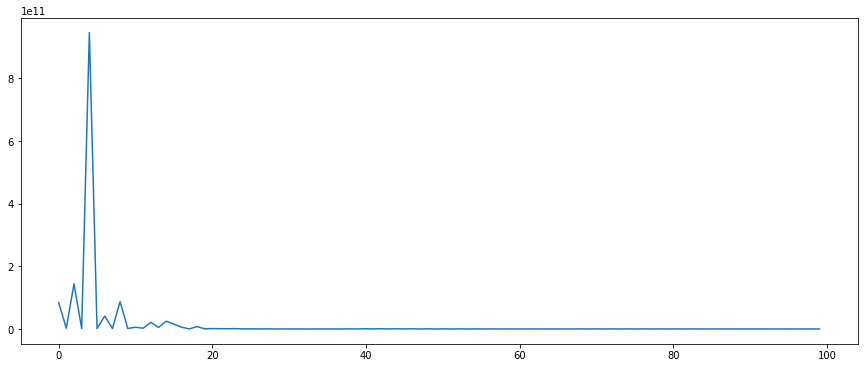

In [18]:
def plot_cost(cost):
    plt.figure(figsize=(15, 6))
    plt.plot(cost)

plot_cost(cost)

In [19]:
def get_top_N_artists(pref_arr, user_list, N=5):

    U_len, I_len = pref_arr.shape

    rankings = []
    for user_id in user_list:
        ranked = np.argsort(estimated_preference[user_id])
        top_artists = list(ranked[::-1][:N])

        rankings.append((user_id, top_artists))
    
    return rankings

In [20]:
get_top_N_artists(estimated_preference, [0, 20, 60])

[(0, [197, 181, 1089, 2029, 992]),
 (20, [505, 157, 197, 66, 148]),
 (60, [157, 1403, 608, 505, 701])]

In [21]:
get_top_N_artists(estimated_preference, [1])

[(1, [197, 505, 181, 435, 739])]